# Importy, wizualizacja
(Należy odpalić i schować).

In [1]:
%matplotlib inline

import torch

from torch import nn
from torch.utils.data import Subset
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Lambda, Compose

import matplotlib.pyplot as plt

import numpy as np

from sklearn.decomposition import PCA

def plot_dataset(train_data, model):
    view_data = train_data.data[:5].view(-1, 28*28) / 255.
    _, decoded_data = model.forward(train_data.data[:5].view(-1, 784).float().cuda() / 255.)
    decoded_data = decoded_data.cpu().detach().numpy()

    n_rows = 2 if decoded_data is not None else 1
    n_cols = len(view_data)
    plt.suptitle("Reconstruction")
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
    
    if decoded_data is not None:
        for i in range(n_cols):
            axes[0][i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap='gray')
            axes[0][i].set_xticks(())
            axes[0][i].set_yticks(())
        
        for i in range(n_cols):
            axes[1][i].clear()
            axes[1][i].imshow(np.reshape(decoded_data[i], (28, 28)), cmap='gray')
            axes[1][i].set_xticks(())
            axes[1][i].set_yticks(())
    
    else:
        for i in range(n_cols):
            axes[i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap='gray')
            axes[i].set_xticks(())
            axes[i].set_yticks(())
    
    plt.show()

def plot_pca(data, model):
    labels = data.classes
    plt.suptitle("Reduction of latent space")
    _ = plt.figure(figsize=(10, 6))
    pca = PCA(2)

    z = model.encode(train_data.data.view(-1, 784).float().cuda())
    reduced_z = pca.fit_transform(z.detach().cpu().numpy())
    
    for class_idx in range(10):
        indices = (data.targets == class_idx)
        plt.scatter(
            reduced_z[indices, 0], reduced_z[indices, 1],
            s=2., label=labels[class_idx])

    plt.legend()
    plt.show()


torch.manual_seed(1337) 
batch_size = 128 
transforms = Compose([ToTensor(), Lambda(lambda x: x.flatten())])

# Mnist dataset
train_data = MNIST(root='.', 
                   train=True, 
                   transform=transforms,    
                   download=True) # change to false if you already have the data

# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

# Auoenkoder i modele generatywne

Na dzisiejszych zajęciach poznamy model autoenkodera i pokażemy, kolejno:
1. Jak jego ukrytą reprezentację można wykorzystać do uczenia częściowo nadzorowanego
2. Jak można wymusić na autoenkoderze generatywność i "zmusić" go do generowania nowych przykładów podobnych do tych ze zbioru treningowego.


## Podstawowy autoenkoder

![Auto-encoder](https://raw.githubusercontent.com/gmum/ml2020-21/master/lab/resources/ae.png)

Autoenkoder rozumiemy jako sieć neuronową, która na wyjściu ma odtwarzać ten sam obiekt, który dostaje na wejściu. Zazwyczaj na autoenkoder patrzymy jako na połączenie dwóch modeli: enkodera $\mathcal{E}$ i dekodera $\mathcal{D}$. Interpretujemy działanie modelu w następujący sposób: enkoder kompresuje wejściowy przykład $x$ do wektora $y$, o którym myślimy jako o reprezentacji ukrytej. Dekoder na podstawie wektora $y$ produkuje $\hat{x}$, które ma aproksymować oryginalne wejście $x$. Tzn.:

$$
y = \mathcal{E} x \\
\hat{x} = \mathcal{D} y
$$

Funkcją kosztu w autoenkoderze będzie MSE pomiędzy wejściem a wyjściem:
$$
\mathcal{L}_{AE} =\frac{1}{n}\sum_i \|x_i-\mathcal{D}\mathcal{E} x_i\|_2^2,
$$
 

Enkoder i dekoder mogą być dowolnymi sieciami neuronowymi, najczęściej jednak dekoder składa się z tych samych transformacji co enkoder w odwrotnej kolejności.  

## Zadanie 1. Vanilla Autoencoder (1 pkt.)

Należy zaimplementować enkoder i dekoder. Kolejne warstwy w enkoderze mają mieć następującą liczbę neuronów: [784, 128, 128, 64, `latent_dim`]. Analogicznie dekoder ma wyglądać następująco: [`latent_dim`, 64, 128, 128, 784]. Wejście i wyjście mają 784 neurony, jako że taka jest wymiarowość MNIST-a. Wartość `latent_dim` dostajemy na wejściu do konstruktora (`latent_dim`).

Po warstwach ukrytych chcemy mieć aktywacje ReLU, **na końcu enkodera nie stosujemy żadnej aktywacji**, na końcu dekodera stosujemy aktywację sigmoidalną.

**Pytanie: Dlaczego na końcu dekodera chcemy mieć sigmoidę?**

In [2]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, latent_dim):
        
        super(AutoEncoder, self).__init__()
        
        self.latent_dim = latent_dim
        
        D = latent_dim
        self.encoder = nn.Sequential(nn.Linear(784,128), nn.ReLU(), nn.Linear(128,128),
                                     nn.ReLU(), nn.Linear(128,64), nn.ReLU(), nn.Linear(64,D))
        self.decoder = nn.Sequential(nn.Linear(D,64), nn.ReLU(), nn.Linear(64,128),
                                     nn.ReLU(), nn.Linear(128,128), nn.ReLU(), nn.Linear(128,784), nn.Sigmoid())
        
    def decode(self, encoded):
        return self.decoder(encoded)
    
    def encode(self, x):
        return self.encoder(x)

    def forward(self, x):
        # encode and decode
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return encoded, decoded

Epoch: 0  |  train loss: 0.0498


<Figure size 432x288 with 0 Axes>

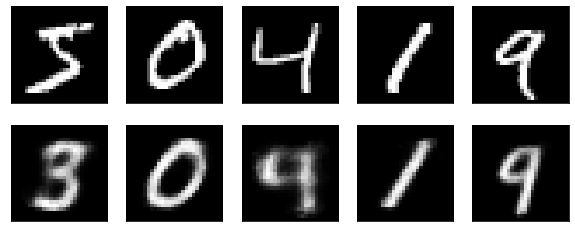

<Figure size 432x288 with 0 Axes>

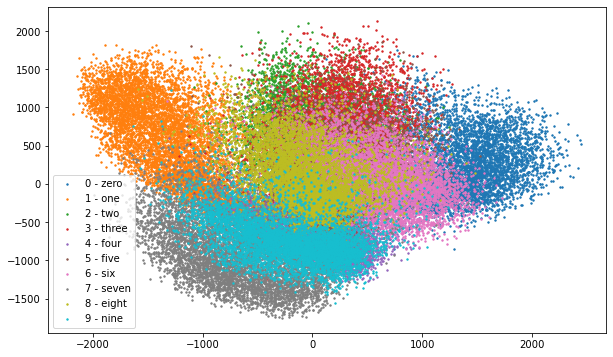

Epoch: 1  |  train loss: 0.0286
Epoch: 2  |  train loss: 0.0238
Epoch: 3  |  train loss: 0.0210
Epoch: 4  |  train loss: 0.0197
Epoch: 5  |  train loss: 0.0188
Epoch: 6  |  train loss: 0.0180
Epoch: 7  |  train loss: 0.0174
Epoch: 8  |  train loss: 0.0170
Epoch: 9  |  train loss: 0.0166
Epoch: 10  |  train loss: 0.0164


<Figure size 432x288 with 0 Axes>

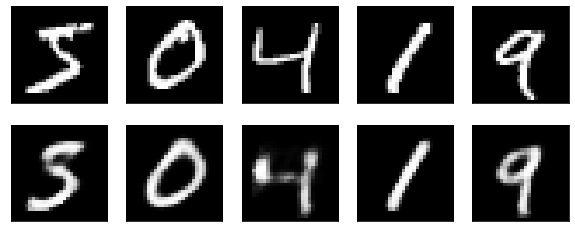

<Figure size 432x288 with 0 Axes>

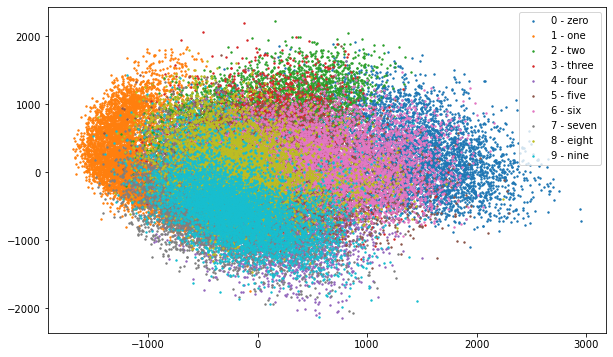

Epoch: 11  |  train loss: 0.0162
Epoch: 12  |  train loss: 0.0160
Epoch: 13  |  train loss: 0.0158
Epoch: 14  |  train loss: 0.0157
Epoch: 15  |  train loss: 0.0156
Epoch: 16  |  train loss: 0.0155
Epoch: 17  |  train loss: 0.0154
Epoch: 18  |  train loss: 0.0153
Epoch: 19  |  train loss: 0.0152
Epoch: 20  |  train loss: 0.0151


<Figure size 432x288 with 0 Axes>

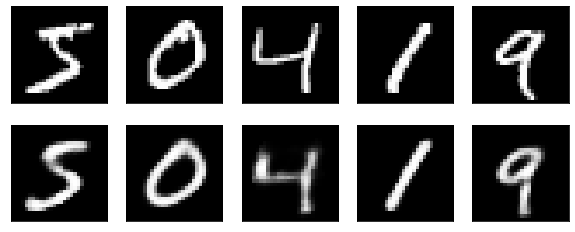

<Figure size 432x288 with 0 Axes>

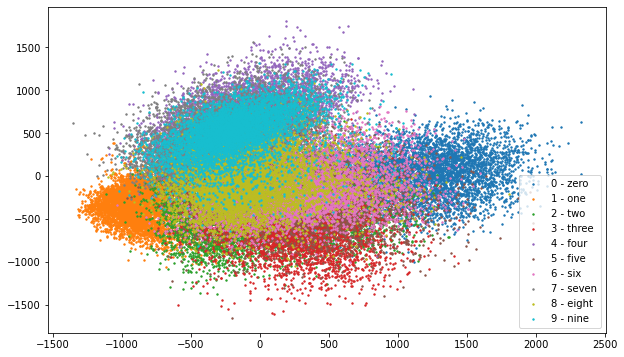

Epoch: 21  |  train loss: 0.0150
Epoch: 22  |  train loss: 0.0149
Epoch: 23  |  train loss: 0.0149
Epoch: 24  |  train loss: 0.0149


In [3]:
# Hyper Parameters
epochs = 25
LR = 5e-3         # learning rate

# prepare original data for plotting

autoencoder = AutoEncoder(latent_dim=10).cuda()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
rec_loss_fn = torch.nn.MSELoss()

for epoch in range(epochs):
    epoch_losses = []  # For logging purposes
    for step, (x, y) in enumerate(train_loader):
        x = x.cuda()
        encoded, decoded = autoencoder(x) 
        loss_val = rec_loss_fn(decoded, x) # calculate loss
        optimizer.zero_grad()        # clear gradients for this training step
        loss_val.backward()          # backpropagation, compute gradients
        optimizer.step()             # apply gradients
        
        epoch_losses.append(loss_val.item())

    print(f'Epoch: {epoch}  |  train loss: {np.mean(epoch_losses):.4f}')

    if epoch % 10 == 0:
        plot_dataset(train_data, autoencoder)
        plot_pca(train_data, autoencoder)

## Część 1: Uczenie częściowo nadzorowane (semi-supervised learning)

W praktyce zbudowanie w pełni nadzorowanego zbioru danych często jest kosztowne. Jeżeli chcielibyśmy uczyć się klasyfikacji obrazków naturalnych, to zdobycie dużych zbiorów danych nie jest trudne (możemy je zescrapować z internetu), natomiast zdobycie do nich etykiet wymagałoby czasu człowieka, który zidentyfikowałby, co się znajduje na poszczególnych obrazkach. W niektórych przypadkach etykietowanie jest jeszcze bardziej kosztowne - w zagadnieniu segmentacji, gdzie chcemy każdemu pikselowi w obrazku przypisać jedną klasę, zapisanie etykiety dla jednego obrazka może zająć ekspertowi kilka godzin.

Problem liczby etykiet i ich jakości jest w praktyce bardzo istotny. Dlatego też w praktyce chcielibyśmy mieć metody głębokiego uczenia, które potrafią wykorzystać dane, dla których nie mamy etykiet. W poniższym przykładzie zbudujemy prosty model częściowo nadzorowany z wykorzystaniem autoenkodera.


## Zadanie 2. Uczenie częściowo nadzorowane (3 pkt.)

Załóżmy, że z 60.000 przykładów zbiorze MNIST tylko 100 przykładów ma podaną etykietę, a dla pozostałych 59.900 nie mamy etykiety - tym samym mamy problem uczenia częściowo nadzorowanego. Nasze 100 przykładów z etykietami zdefiniowane są w zmiennej `labeled_data`.

1. Zaimplementuj i wytrenuj sieć neuronową (klasyfikator), która uczy się wyłącznie bezpośrednio na 100 podanych przykładach. Po wytrenowaniu wypisz accuracy na zbiorze testowym, jaki udało Ci się uzyskać. Sieć powinna być względnie mała (max 4 warstwy, max 128 neuronów w warstwie). Zapisz wynik.
2. Zaimplementuj i wytrenuj sieć neuronową (klasyfikator) o podobnej architekturze co w poprzednim punkcie, również na datasecie 100 przykładów, ale tym razem niech wejściem do sieci będzie ukryta reprezentacja $y = \mathcal{E}x$ stworzona przez autoenkoder wytrenowany w Zadaniu 1. Zapisz wynik.
3. Porównaj wyniki obu modeli. Wskaż, który nauczył się lepiej i podaj hipotezę dlaczego.


In [4]:
labeled_data = Subset(train_data, range(100))
labeled_loader = torch.utils.data.DataLoader(dataset=labeled_data, batch_size=32, shuffle=True)

test_data = MNIST(root='.', 
                   train=False, 
                   transform=transforms,    
                   download=True) # change to false if you already have the data
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=5000, shuffle=True)

In [20]:
### Tutaj zaimplementuj i wytrenuj model baseline'owy
class Model(torch.nn.Module):
    def __init__(self, output_dim):
        super(Model, self).__init__()
        self.neural_network = nn.Sequential(nn.Linear(784,128), nn.ReLU(), nn.Linear(128,128),
                                     nn.ReLU(), nn.Linear(128,64), nn.ReLU(), nn.Linear(64,output_dim))
    def forward(self, x):
        return self.neural_network(x)
     
epochs = 40
LR = 5e-3 
model = Model(output_dim=10)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
rec_loss_fn = torch.nn.MSELoss()

for epoch in range(epochs):
    for step, (x, y) in enumerate(labeled_loader):
        result = model.forward(x)
        loss = criterion(result, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        correct = 0 
        for i, (x, y) in enumerate(test_loader):
            result = model(x)
            correct += float(torch.sum(torch.max(result,1)[1]-y==0).item())
        print(f"\nTest accuracy: {correct / len(test_data)}")


Test accuracy: 0.2744

Test accuracy: 0.4168

Test accuracy: 0.5122

Test accuracy: 0.4678

Test accuracy: 0.5067

Test accuracy: 0.5433

Test accuracy: 0.6605

Test accuracy: 0.6352

Test accuracy: 0.628

Test accuracy: 0.5852

Test accuracy: 0.584

Test accuracy: 0.646

Test accuracy: 0.6537

Test accuracy: 0.6481

Test accuracy: 0.6396

Test accuracy: 0.6355

Test accuracy: 0.6451

Test accuracy: 0.6544

Test accuracy: 0.6601

Test accuracy: 0.6622

Test accuracy: 0.6646

Test accuracy: 0.6656

Test accuracy: 0.6663

Test accuracy: 0.6672

Test accuracy: 0.6662

Test accuracy: 0.6655

Test accuracy: 0.6641

Test accuracy: 0.6638

Test accuracy: 0.6628

Test accuracy: 0.6614

Test accuracy: 0.6611

Test accuracy: 0.6608

Test accuracy: 0.6605

Test accuracy: 0.6612

Test accuracy: 0.6606

Test accuracy: 0.6602

Test accuracy: 0.6604

Test accuracy: 0.6609

Test accuracy: 0.6612

Test accuracy: 0.6609


In [36]:
### Tutaj zaimplementuj i wytrenuj klasyfikator oparty o reprezentację podaną przez autoenkoder.

epochs = 40
LR = 5e-3 
model = Model(output_dim=10).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
rec_loss_fn = torch.nn.MSELoss()

for epoch in range(epochs):
    for step, (x, y) in enumerate(labeled_loader):
        x = x.cuda()
        encoded, decoded = autoencoder(x) 
        result = model(decoded)
        loss = criterion(result, y.cuda())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        correct = 0 
        for i, (x, y) in enumerate(test_loader):
            x = x.cuda()
            result = model(x)
            correct += float(torch.sum(torch.max(result,1)[1]-y.cuda()==0).item())
        print(f"\nTest accuracy: {correct / len(test_data)}")


Test accuracy: 0.3158

Test accuracy: 0.3489

Test accuracy: 0.4556

Test accuracy: 0.5665

Test accuracy: 0.5344

Test accuracy: 0.5684

Test accuracy: 0.6426

Test accuracy: 0.6458

Test accuracy: 0.6077

Test accuracy: 0.6138

Test accuracy: 0.6286

Test accuracy: 0.6949

Test accuracy: 0.7083

Test accuracy: 0.6934

Test accuracy: 0.6834

Test accuracy: 0.7

Test accuracy: 0.6955

Test accuracy: 0.6864

Test accuracy: 0.687

Test accuracy: 0.697

Test accuracy: 0.7025

Test accuracy: 0.7048

Test accuracy: 0.7047

Test accuracy: 0.7034

Test accuracy: 0.7033

Test accuracy: 0.7029

Test accuracy: 0.7019

Test accuracy: 0.7005

Test accuracy: 0.7002

Test accuracy: 0.6995

Test accuracy: 0.6998

Test accuracy: 0.7003

Test accuracy: 0.701

Test accuracy: 0.701

Test accuracy: 0.7016

Test accuracy: 0.7014

Test accuracy: 0.7018

Test accuracy: 0.7024

Test accuracy: 0.7022

Test accuracy: 0.7022


In [ ]:
#Można zauażyć, że accuracy poprawiło się o około 4%. Lepiej nauczył się model drugi, prawdopodobnie prez to, że 
# dane były aproksymowane, czyli obarczone jakimś dodatkowym błędem, który spowodował, że dane testowe lepiej dopasoyały 
#się do modelu.

## Inne zagadnienia uczenia ze słabym nadzorem
Podany powyżej przykład jest bardzo prostym podejściem do problemu uczenia danych ze słabym nadzorem. Dla zainteresowanych trochę więcej materiałów:

* [Praca przeglądowa o problemie słabego nadzoru](https://academic.oup.com/nsr/article-pdf/5/1/44/31567770/nwx106.pdf)
* [Pseudo-labeling do uczenia częściowo nazdorowanego](https://github.com/emintham/Papers/blob/master/Lee-%20Pseudo-Label:%20The%20Simple%20and%20Efficient%20Semi-Supervised%20Learning%20Method%20for%20Deep%20Neural%20Networks.pdf) - W tym podejściu do uczenia częściowo nadzorowanego trenujemy model na poetykietowanych danych, używamy jego predykcji żeby poetykietować resztę danych i uczymy model z takimi (narzuconymi przez siebie) etykietami. Wbrew intuicji to podejście dziala całkiem dobrze.
* [Przegląd metod self-supervision](https://lilianweng.github.io/lil-log/2019/11/10/self-supervised-learning.html) - Czy możemy się uczyć z danych na podstawie łatwych do otrzymania etykiet (np. o ile stopni zdjęcie zostało obrócone)?

# Część 2: Modele generatywne

Interesującym zastosowaniem sieci neuronowych jest generowanie nowych przykładów ze zbioru treningowego, np. [generowanie nowych twarzy](https://thispersondoesnotexist.com/) albo [generowanie tekstu](https://transformer.huggingface.co/doc/gpt2-large). Na dzisiejszych zajęciach spróbujemy zbudować prosty model generatywny oparty o autoenkoder.

100.0%

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw


111.0%

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw


100.0%

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw


159.1%/home/jakub/.conda/envs/ml_exercises/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370141920/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw
Processing...
Done!


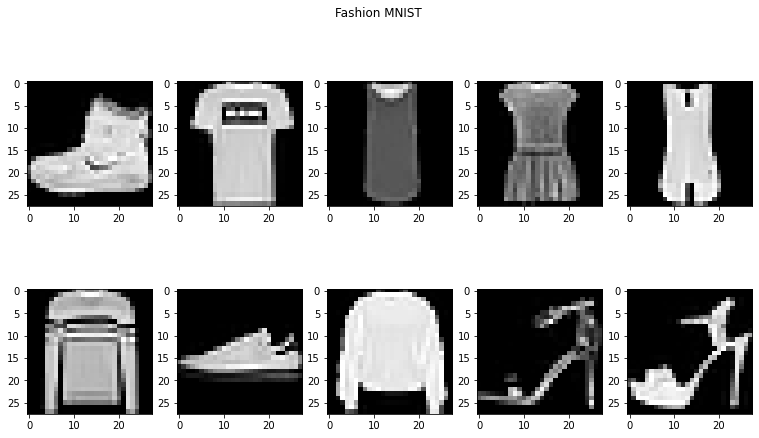

In [37]:
from torchvision.datasets import FashionMNIST


# FashionMNIST dataset
transforms = Compose([ToTensor(), Lambda(lambda x: x.flatten())])
train_data = FashionMNIST(root='.', 
                   train=True, 
                   transform=transforms,    
                   download=True)

batch_size = 256
# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True) 

_, axes = plt.subplots(2, 5, figsize=(13, 7))
for im, ax in zip(train_data.data[:10], axes.reshape(-1)):
    ax.imshow(im, cmap='gray')
plt.suptitle("Fashion MNIST")
plt.show()

## Wasserstein Autoencoder
Kolejnym zadanie będzie zaimplementowanie Autoenkodera Wassersteina (Wasserstein Autoencoder) z kosztem Maximum Mean Discrepancy. Model ten jest identyczny w architekturze do zwyczajnego autoenkodera prezentowanego na początku zajęć, ale dodatkowo wymusza żeby przykłady w przestrzeni ukrytej układały się w rozkład normalny. Dzięki temu po nauczeniu będziemy mogli generować nowe przykłady, samplując szum z rozkładu normalnego i przepuszczając go przez dekoder naszego autoenkodera.

W rezultacie WAE składa się ponownie z dwóch komponentów: Enkodera $\mathcal{E}$ oraz dekodera $\mathcal{D}$. Funkcja kosztu wygląda teraz następująco:

$$
\mathcal{L}_{WAE-MMD} =\frac{1}{n}\sum_i \|x_i-\mathcal{D}\mathcal{E} x_i\|^2+
C d^2_k((\mathcal{E} x_i),(z_j)),
$$

gdzie $z_j$ to sample wygenerowane z rozkładu normalnego $\mathcal{N}(0, I)$ a $C \in \mathcal{R}$ to hiperparametr ważący komponenty funkcji kosztu.

Pierwszy człon kosztu to koszt rekonstrukcji taki sam jak w przypadku zwyczajnego autoenkodera. Drugi człon funkcji kosztu to koszt MMD, zadany wzorem: 
$$
d^2_k((y_i),(z_j))=\frac{1}{n^2}\sum_{i,i'}k(y_i,y_{i'})+\frac{1}{n^2}\sum_{j,j'}k(z_j,z_{j'})-\frac{2}{n^2}\sum_{i,j}k(y_i,z_j),
$$
gdzie $k$ to wybrany przez nas kernel.

Koszt ten opisuje odległość pomiędzy reprezentacją ukrytą $y_i = \mathcal{E}x_i$ otrzymaną po przepuszczeniu przykładów treningowych przez enkoder a samplami $z_i$ wygenerowanymi z rozkładu normalnego $\mathcal{N}(0, I)$. Tym samym minimalizując ten koszt sprawimy że rozkład zadany przez enkoder będzie bardziej podobny do rozkładu normalnego, do którego chcemy się dopasować.

Na potrzeby zadania proszę skorzystać z kernela IMQ (inverse multi-quadratic) zadanego wzorem:
$$
k(y, z)=\frac{\sigma}{\sigma+\|y - z \|^2},
$$
gdzie $\sigma$ to hiperparametr, który trzeba znaleźć. 


**Pytanie: W kontekście kosztu MMD, dlaczego w Zadaniu 1 nie chcieliśmy mieć aktywacji na końcu enkodera?**


## Zadanie 3: WAE-MMD (3 pkt.)
W ramach zadania należy:
1. Zaimplementować architekturę autoenkodera (enkoder + dekoder), podobną do tej zaprezentowanej w Zadaniu 1. Jako że dataset FMNIST jest trudniejszy, to architektura też powinna być istotnie większa (np. 50 wymiarów przestrzeni ukrytej).
2. Zaimplementować pętlę uczenia WAE, w której minimalizujemy koszt $\mathcal{L}_{WAE-MMD}$.
3. Dostosować hiperparametry (learning rate, liczba epok, $C$, $\sigma$, etc.), tak żeby rekonstrukcja i generowane sample wyglądały na poziomie porównywalnym do tych pokazanych poniżej (albo lepiej). Zacznij od $C=1$, $\sigma = 2D$, gdzie $D$ to wymiar przestrzeni ukrytej.

W razie potrzeby można wspomóc się materiałami z wykładu, [oryginalną pracą o autoenkoderze Wassersteina](https://arxiv.org/abs/1711.01558) (interesuje nas zwłaszcza strona piąta, Algorytm 2 WAE-MMD) oraz [oficjalnie dostępną implementacją](https://github.com/tolstikhin/wae). 



In [83]:
#Zadnie 3 niedokończone
class WAEMMD(nn.Module):
    
    def __init__(self, latent_dim):
        
        super(WAEMMD, self).__init__()
        
        self.latent_dim = latent_dim
        D = latent_dim
        self.encoder = nn.Sequential(nn.Linear(784,128), nn.ReLU(), 
                                     nn.Linear(128,128),nn.ReLU(), nn.Linear(128,128),nn.ReLU(), nn.Linear(128,128),nn.ReLU(),
                                     nn.Linear(128,128),nn.ReLU(), nn.Linear(128,128),nn.ReLU(), nn.Linear(128,128),nn.ReLU(), 
                                     nn.Linear(128,128),nn.ReLU(), nn.Linear(128,128),nn.ReLU(), nn.Linear(128,128),nn.ReLU(),
                                     nn.Linear(128,128),nn.ReLU(), nn.Linear(128,128),nn.ReLU(), nn.Linear(128,128),nn.ReLU(), 
                                     nn.Linear(128,128),nn.ReLU(), nn.Linear(128,128),nn.ReLU(), nn.Linear(128,128),nn.ReLU(),
                                     nn.Linear(128,128),nn.ReLU(), nn.Linear(128,128),nn.ReLU(), nn.Linear(128,128),nn.ReLU(),
                                     nn.ReLU(), nn.Linear(128,64), nn.ReLU(), nn.Linear(64,latent_dim))
        self.decoder = nn.Sequential(nn.Linear(latent_dim,64), nn.ReLU(), nn.Linear(64,128),
                                     nn.Linear(128,128),nn.ReLU(), nn.Linear(128,128),nn.ReLU(), nn.Linear(128,128),nn.ReLU(),
                                     nn.Linear(128,128),nn.ReLU(), nn.Linear(128,128),nn.ReLU(), nn.Linear(128,128),nn.ReLU(), 
                                     nn.Linear(128,128),nn.ReLU(), nn.Linear(128,128),nn.ReLU(), nn.Linear(128,128),nn.ReLU(),
                                     nn.Linear(128,128),nn.ReLU(), nn.Linear(128,128),nn.ReLU(), nn.Linear(128,128),nn.ReLU(), 
                                     nn.Linear(128,128),nn.ReLU(), nn.Linear(128,128),nn.ReLU(), nn.Linear(128,128),nn.ReLU(),
                                     nn.Linear(128,128),nn.ReLU(), nn.Linear(128,128),nn.ReLU(), nn.Linear(128,128),nn.ReLU(),
                                     nn.Linear(128,784), nn.Sigmoid())
        
    def decode(self, encoded):
         return self.decoder(encoded)
    
    def encode(self, x):
         return self.encoder(x)

    def forward(self, x):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return encoded, decoded
    
    def mmd_loss(self, y, sigma):
        y = y.float()
        def k(x1,x2):
            return sigma / (sigma + torch.norm(x1-x2)**2)
        
        def sum_of_vect(x1,x2):
            suma=0
            for i in x1:
                for j in x2:
                    suma+= k(i,j)
            return suma
        z = torch.empty(len(y)).normal_(mean=0,std=1)           
        return sum_of_vect(y,y)/len(y)**2 + sum_of_vect(z,z)/len(y)**2 - 2*sum_of_vect(z,y)/len(y)**2
        

In [87]:
def plot_samples(model):
    # Important part - sampling from normal distribution and passing the results through the decoder.
    sampled_z = torch.randn(20, model.latent_dim).cuda()
    generated = model.decode(sampled_z)

    # Plotting the results
    generated = generated.cpu().detach().numpy()
    _, axes = plt.subplots(2, 10, figsize=(15, 4))
    for gen_im, ax in zip(generated, axes.reshape(-1)):
        ax.imshow(gen_im.reshape(28, 28), cmap="gray")
    plt.suptitle("Generated samples")
    plt.show()

wae = WAEMMD(latent_dim=10)
optimizer = torch.optim.Adam(wae.parameters(), lr=LR)
sigma = 2  
C = 1
epochs = 10

for epoch in range(epochs):
    for step, (x, y) in enumerate(train_loader):
        print(step)
        encoded, decoded = wae(x)
        loss_val = rec_loss_fn(decoded, x) + C*wae.mmd_loss(y,sigma)
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
    if epoch % 10 == 0:
        plot_dataset(train_data, wae)
        plot_pca(train_data, wae)
        plot_samples(wae)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234


RuntimeError: CUDA error: unspecified launch failure

In [ ]:
epochs = 25
LR = 5e-3         # learning rate

# prepare original data for plotting

autoencoder = AutoEncoder(latent_dim=10).cuda()

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
rec_loss_fn = torch.nn.MSELoss()

for epoch in range(epochs):
    epoch_losses = []  # For logging purposes
    for step, (x, y) in enumerate(train_loader):
        x = x.cuda()
        encoded, decoded = autoencoder(x) 
        loss_val = rec_loss_fn(decoded, x) # calculate loss
        optimizer.zero_grad()        # clear gradients for this training step
        loss_val.backward()          # backpropagation, compute gradients
        optimizer.step()             # apply gradients
        
        epoch_losses.append(loss_val.item())

    print(f'Epoch: {epoch}  |  train loss: {np.mean(epoch_losses):.4f}')

    if epoch % 10 == 0:
        plot_dataset(train_data, autoencoder)
        plot_pca(train_data, autoencoder)

## Więcej materiałów o modelach generatywnych

* [Tutorial o GAN-ach](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) - bardzo popularna i potężna rodzina modeli generatywnych, które słyną z niestabilnego procesu trenowania.
* [Wykład o uczeniu nienadzorowanym i VAE](https://www.youtube.com/watch?v=f0s-uvvXvWg&list=PLqYmG7hTraZCDxZ44o4p3N5Anz3lLRVZF&index=10) - Interesujący wykład badaczy z DeepMindu zagłebiający się w to, dlaczego nienadzorowane uczenie się reprezentacji jest cenne i jak wykorzystać do tego VAE (model podobny do WAE). Polecamy też pozostałe wykłady z serii.
* [Cramer-Wold Autoencoder](https://arxiv.org/abs/1805.09235) - jak zaimplementować koszt WAE-MMD bez potrzeby samplowania w przestrzeni ukrytej?
